<h2>Initialise files</h2>

In [110]:
import pandas as pd
import math
from functools import reduce

Declare variables constant

In [111]:
FILE_PATH = "2021-06-27-AccountStatement.csv"
TABLE_NAMES = ['Cash Balance', 'Account Trade History', 'Equities', 'Options', 'Profits and Losses']

def parse_key(key): 
    return key.lower().replace(" ", "_")

def build_map(acc, cur): 
    new_acc = {parse_key(acc): acc} if isinstance(acc, str) else acc  
    key = parse_key(cur)
    new_acc[key] = cur
    return new_acc

table_map = reduce(build_map, TABLE_NAMES)   
print(table_map)

table_length = len(TABLE_NAMES)

def parse_row_list(row_list, table_name): 
    """
    Remove last row for the tables with total, 
    as this will disrupt with the data transformation process.
    i.e.  cash balance, equities and profits and losses 
    """
    table_names_to_remove = ['Cash Balance', 'Equities', 'Profits and Losses']
    
    if table_name in table_names_to_remove: 
        row_list.pop()
        return row_list 
    
    return row_list
    

{'cash_balance': 'Cash Balance', 'account_trade_history': 'Account Trade History', 'equities': 'Equities', 'options': 'Options', 'profits_and_losses': 'Profits and Losses'}


In [112]:
import csv

def split_csv(csv_path, table_names): 
    tables_infos = detect_tables_from_csv(csv_path, table_names)
    
def create_output_file_and_return_writer(file_name): 
    row_list = []
    output_file = open(f'generated/{file_name}.csv', 'w',  newline='')
    writer =  csv.writer(output_file)
    return [row_list, output_file, writer]
    
def detect_tables_from_csv(csv_path, table_names): 
    file = open(csv_path, 'r')
    csv_reader = csv.reader(file)
    
    current_table_idx = 0
    [row_list, output_file, writer] = create_output_file_and_return_writer(TABLE_NAMES[current_table_idx])
    push_to_table = False 
    
    for  row in csv_reader: 
        if len(row) == 0: 
            if push_to_table == True:
                push_to_table = False
                parsed_rl = parse_row_list(row_list, TABLE_NAMES[current_table_idx])
                writer.writerows(parsed_rl)
                output_file.close()
                current_table_idx += 1 
                if(current_table_idx < table_length):
                    [row_list, output_file, writer] = create_output_file_and_return_writer(TABLE_NAMES[current_table_idx])
            continue
        
        first_data = row[0]
        if push_to_table == True: 
            # for some reasons all the 
            row_itme = first_data.split(',')
            row_list.append(row)
            continue
        
            
        if first_data in TABLE_NAMES: 
            push_to_table = True
            continue 

In [113]:
split_csv(FILE_PATH, TABLE_NAMES)

<h2>Create individual ticker chart</h2>

<strong>Initialise dataframe</strong>

In [114]:
FILE_PATH = f'generated/{table_map["cash_balance"]}.csv'
df = pd.read_csv(FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE                1368 non-null   object 
 1   TIME                1368 non-null   object 
 2   TYPE                1368 non-null   object 
 3   REF #               1190 non-null   float64
 4   DESCRIPTION         1368 non-null   object 
 5   Misc Fees           1019 non-null   float64
 6   Commissions & Fees  947 non-null    float64
 7   AMOUNT              1158 non-null   object 
 8   BALANCE             1368 non-null   object 
dtypes: float64(3), object(6)
memory usage: 96.3+ KB


In [115]:
def convert_currency(value): 
    """
    Convert string number value to float 
    - Remove commas 
    - Convert to float type
    """
    if isinstance(value, float): 
        return value
    
    new_val = value.replace(',','')
    return float(new_val)

<h3>Parse description into relevant columns</h3>

In [116]:
'''
example description: 
SOLD -1 VERTICAL PINS 100 19 FEB 21 60/55 PUT @.94 PHLX 
BOT +5 BABA @229.40
SOLD -1 NIO 100 19 FEB 21 40 PUT @2.23 BOX
'''
# net_qty refers to the first qty with the +|- symbol
net_qty_regex = '((\+|-)\d+)'

# qty_with_weekly refers to the numerical qty just before the date
qty_with_weekly_regex = f'\s\d+(?:\s\(Weeklys\))?'
date_regex = '\s(([0][1-9]|[12]?\d|3[01])\s(JAN|FEB|MA[RY]|APR|JU[NL]|AUG|SEPT?|OCT|NOV|DEC)\s(\d{2}))'
symbol_regex = f'\s([A-Z]+){qty_with_weekly_regex}{date_regex}'
spread_regex = f'\d\s([A-Z\s]+){symbol_regex}'

df['Datetime'] = pd.to_datetime(df['DATE'] +' ' + df['TIME'])
df['AMOUNT'] = df['AMOUNT'].apply(lambda x: x if isinstance(x, str) == False and math.isnan(x) else convert_currency(x)) 

df['Symbol'] = df['DESCRIPTION'].str.extract(symbol_regex, expand=True)[0]
df['Spread'] = df['DESCRIPTION'].str.extract(spread_regex, expand=True)[0]
df['Qty'] = df['DESCRIPTION'].str.extract(net_qty_regex, expand=True)[0]
df['Exp'] =  df['DESCRIPTION'].str.extract(date_regex, expand=True)[0]

df.head()

,DATE,TIME,TYPE,REF #,DESCRIPTION,Misc Fees,Commissions & Fees,AMOUNT,BALANCE,Datetime,Symbol,Spread,Qty,Exp
0,1/1/21,14:00:00,BAL,NaN,Cash balance at the start of business day 01.0...,NaN,NaN,NaN,"4,326.72",2021-01-01 14:00:00,NaN,NaN,NaN,NaN
1,1/2/21,14:00:00,BAL,NaN,Cash balance at the start of business day 02.0...,NaN,NaN,NaN,"4,326.72",2021-01-02 14:00:00,NaN,NaN,NaN,NaN
2,1/3/21,14:00:00,BAL,NaN,Cash balance at the start of business day 03.0...,NaN,NaN,NaN,"4,326.72",2021-01-03 14:00:00,NaN,NaN,NaN,NaN
3,1/4/21,14:00:00,BAL,NaN,Cash balance at the start of business day 04.0...,NaN,NaN,NaN,"4,326.72",2021-01-04 14:00:00,NaN,NaN,NaN,NaN
4,1/4/21,14:00:00,WIN,3.773536e+09,WIRE INCOMING,NaN,NaN,15176.0,"19,502.72",2021-01-04 14:00:00,NaN,NaN,NaN,NaN


<h2>Generate new excel sheet</h2>

In [117]:
df.to_csv('generated/output.csv')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                1368 non-null   object        
 1   TIME                1368 non-null   object        
 2   TYPE                1368 non-null   object        
 3   REF #               1190 non-null   float64       
 4   DESCRIPTION         1368 non-null   object        
 5   Misc Fees           1019 non-null   float64       
 6   Commissions & Fees  947 non-null    float64       
 7   AMOUNT              1158 non-null   float64       
 8   BALANCE             1368 non-null   object        
 9   Datetime            1368 non-null   datetime64[ns]
 10  Symbol              1003 non-null   object        
 11  Spread              191 non-null    object        
 12  Qty                 1067 non-null   object        
 13  Exp                 1003 non-null   object      

In [119]:
unique_tickers = df['Symbol'].dropna().unique()
print(unique_tickers)

['NIO' 'PLTR' 'ARKG' 'MSFT' 'PINS' 'JD' 'SPOT' 'SE' 'XBI' 'BABA' 'KO'
 'BIDU' 'XRT' 'BNGO' 'PDD' 'STPK' 'SPCE' 'NNDM' 'CRNT' 'BB' 'AAL' 'AAPL'
 'SENS' 'TELL' 'GEVO' 'PFE' 'TLRY' 'TIGR' 'FRSX' 'SKLZ' 'FVRR' 'IPOE'
 'GLUU' 'REI' 'OGI' 'SNDL' 'TSLA' 'AYRO' 'MU' 'CLOV' 'HYLN' 'CCIV' 'RKT'
 'VUZI' 'FB' 'NOK' 'PLUG' 'WKHS' 'F' 'CVM' 'MVIS' 'OCGN' 'LAZR' 'STEM' 'X'
 'LUMN' 'XOM' 'ZM' 'SOFI' 'ETSY' 'WISH' 'DKNG' 'QQQ' 'U' 'YUM']


<strong>Initialise variables</strong>

In [161]:
TICKER = "XRT"
GREEN = '#29EA38'
RED = '#FB3C62'

<strong>Retrieve chart data</strong>

In [162]:
ticker_data = df[df['Symbol'] == TICKER]
ticker_data.head()

,DATE,TIME,TYPE,REF #,DESCRIPTION,Misc Fees,Commissions & Fees,AMOUNT,BALANCE,Datetime,Symbol,Spread,Qty,Exp
57,1/13/21,23:02:59,TRD,3.824743e+09,SOLD -1 XRT 100 19 FEB 21 76 CALL @.82 PHLX,-0.07,-0.65,82.0,"14,794.94",2021-01-13 23:02:59,XRT,NaN,-1,19 FEB 21
78,1/19/21,22:43:06,TRD,3.847755e+09,SOLD -1 XRT 100 19 FEB 21 67.5 PUT @.36,-0.07,-0.65,36.0,"14,531.29",2021-01-19 22:43:06,XRT,NaN,-1,19 FEB 21
79,1/19/21,22:45:15,TRD,3.847821e+09,SOLD -1 VERTICAL XRT 100 19 FEB 21 69/67.5 PUT...,-0.12,-1.30,31.0,"14,560.87",2021-01-19 22:45:15,XRT,VERTICAL,-1,19 FEB 21
119,1/25/21,22:41:42,TRD,3.877002e+09,SOLD -1 VERTICAL XRT 100 19 FEB 21 72/69 PUT @...,-0.12,-1.30,40.0,"20,198.11",2021-01-25 22:41:42,XRT,VERTICAL,-1,19 FEB 21
120,1/25/21,22:43:27,TRD,3.877079e+09,BOT +1 XRT 100 19 FEB 21 76 CALL @3.90 PHLX,-0.06,-0.65,-390.0,"19,807.40",2021-01-25 22:43:27,XRT,NaN,+1,19 FEB 21


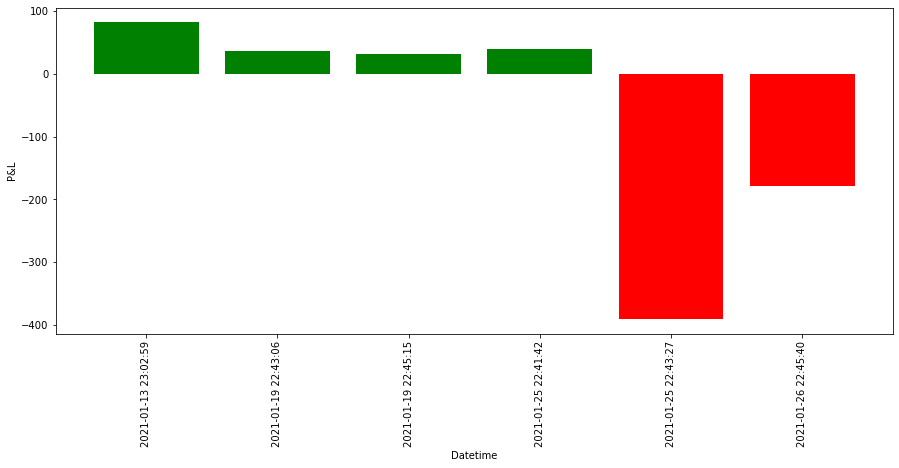

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart

def bar_chart(chart_df): 
    fig = plt.figure(figsize=(15, 6))
    
    index = chart_df['Datetime'].values
    data = {'AMOUNT': chart_df['AMOUNT'].values}
    
    new_dataframe = pd.DataFrame(data=data, index=index)
    new_dataframe['positive'] = new_dataframe['AMOUNT'] > 0
    color_palette = tuple(new_dataframe['positive'].apply(colored).values)
    
    x_values = new_dataframe.reset_index()['index'].apply(transform_to_text).values

    plt.bar(x_values, data['AMOUNT'], color=color_palette)
    plt.xlabel('Datetime')
    plt.xticks(rotation=90)
    plt.ylabel('P&L')
    plt.show()
    
    
def transform_to_text(data):
    return f'{data}'

def colored(data): 
    return 'g' if data else 'r'
    
bar_chart(ticker_data)

In [123]:
'''
Copied from https://github.com/chrispaulca/waterfall/blob/master/waterfall_chart.py
If we are to use the installed package, for some reason fig size can't be change, so we run the code here. 
'''

'''
A function that attempts to generate a standard waterfall chart in generic Python. Requires two sequences,
one of labels and one of values, ordered accordingly.
'''


from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines

#------------------------------------------

def plot(index, data, Title="", x_lab="", y_lab="",
              formatting = "{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
             sorted_value = False, threshold=None, other_label='other', net_label='net', 
             rotation_value = 30, blank_color=(0,0,0,0), figsize=(10,10)):
    '''
    Given two sequences ordered appropriately, generate a standard waterfall chart.
    Optionally modify the title, axis labels, number formatting, bar colors, 
    increment sorting, and thresholding. Thresholding groups lower magnitude changes
    into a combined group to display as a single entity on the chart.
    '''
    
    #convert data and index to np.array
    index=np.array(index)
    data=np.array(data)
    
    # wip
    #sorted by absolute value 
    if sorted_value: 
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]
    
    #group contributors less than the threshold into 'other' 
    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],other_label)
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))
    
    changes = {'amount' : data}
    
    #define format formatter
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(formatter)

    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)
    
    trans['positive'] = trans['amount'] > 0

    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc[net_label]= total
    blank.loc[net_label] = total

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc[net_label] = 0
    
    #define bar colors for net bar
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99
    
    trans['color'] = trans['positive']
    
    trans.loc[trans['positive'] == 1, 'color'] = green_color
    trans.loc[trans['positive'] == 0, 'color'] = red_color
    trans.loc[trans['positive'] == 99, 'color'] = blue_color
    
    my_colors = list(trans.color)
    
    #Plot and label
    my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color=blank_color)
    plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
             bottom=blank, color=my_colors)       
                                   
    
    # connecting lines - figure out later
    #my_plot = lines.Line2D(step.index, step.values, color = "gray")
    #my_plot = lines.Line2D((3,3), (4,4))
    
    #axis labels
    plt.xlabel("\n" + x_lab)
    plt.ylabel(y_lab + "\n")

    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    
    temp = list(trans.amount)
    
    # create dynamic chart range
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]
    
    trans['temp'] = temp
            
    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()
    
    #Make sure the plot doesn't accidentally focus only on the changes in the data
    if all(i >= 0 for i in temp):
        plot_min = 0
    if all(i < 0 for i in temp):
        plot_max = 0
    
    if abs(plot_max) >= abs(plot_min):
        maxmax = abs(plot_max)   
    else:
        maxmax = abs(plot_min)
        
    pos_offset = maxmax / 40
    
    plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*2)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'g', fontsize=9)
        else:
            y -= (pos_offset*4)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'r', fontsize=9)
        loop+=1

    #Scale up the y axis so there is room for the labels
    plt.ylim(plot_min-round(3.6*plot_offset, 7),plot_max+round(3.6*plot_offset, 7))
    
    #Rotate the labels
    plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)
    
    #add zero line and title
    plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
    plt.title(Title)
    plt.tight_layout()

    return fig, ax

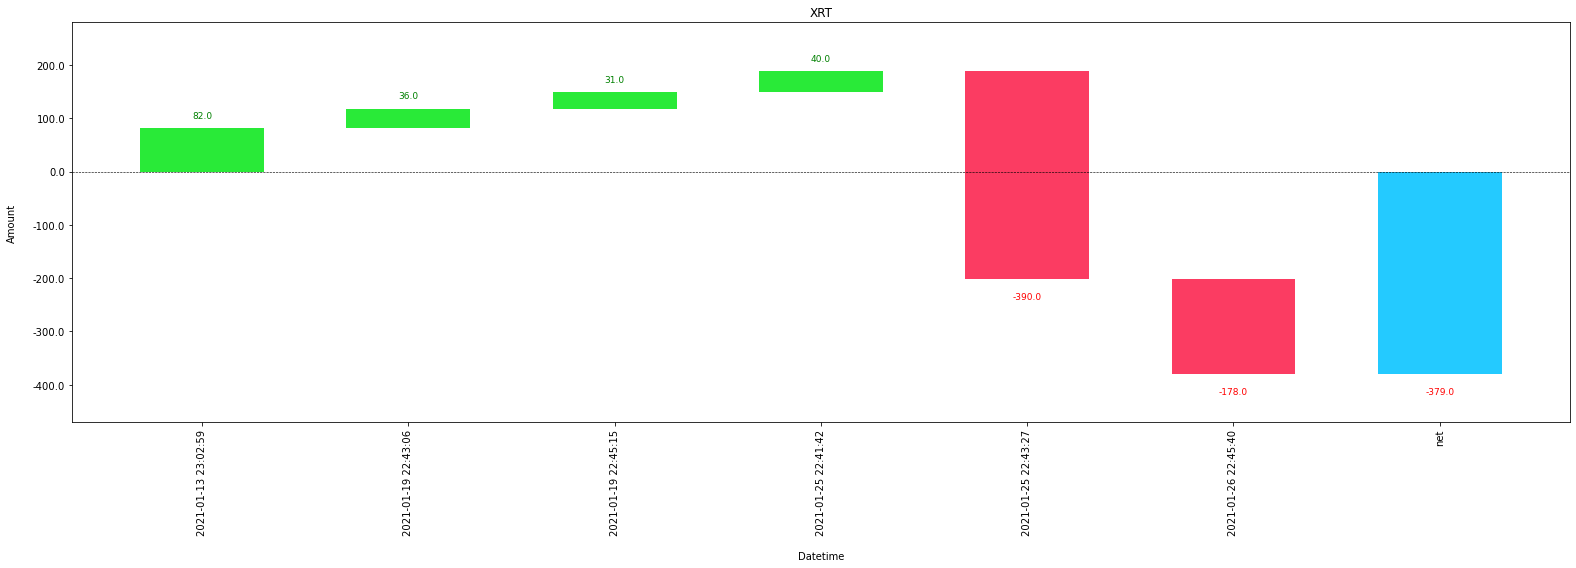

In [199]:
index = ticker_data['Datetime'].values
data = ticker_data['AMOUNT'].values

waterfall_plot = plot(index=index, data=data, rotation_value=90, Title=TICKER, x_lab="Datetime", y_lab="Amount", figsize=(22,8))